# ADP_ML_29

In [20]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font', family = 'Malgun Gothic')

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings(action='ignore')

from imblearn.over_sampling import SMOTE
import xgboost as xgb
import scipy.stats as stats
import math
from scipy.stats import chi2_contingency
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## 데이터 설명
- 데이터 출처 : https://www.data.go.kr/data/15094266/fileData.do 후처리
- 데이터 링크 : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p1.csv
- 데이터 설명 : 대구도시공사_빅데이터_영구임대아파트 입주자 퇴거여부 데이터, 고유번호를 가진 계약자와 특정 아파트에 대해 매년 퇴거여부를 기록한 데이터데이터

In [2]:
url = 'https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p1.csv'
df = pd.read_csv(url, encoding='cp949')

## 1-1  계약자고유번호를 기준으로 거주연도 별 여러개의 데이터가 쌓여 있다. 각 계약자고유번호에 대해 가장 최신의 거주연도 행만 남겨라.

In [3]:
# df['계약자고유번호'].value_counts() # 동일한 계약자고유번호에 여러 데이터가 포함되어 있음 (1172번의 경우 08-12까지 18개 중복 데이터 포함)
result = df.sort_values(['계약자고유번호','거주연도']).drop_duplicates(subset=['계약자고유번호'], keep='last').reset_index(drop=True)
display(result.head(3))
print(f'답안\n계계약자 고유번호와 거주연도 기준으로 정렬하고 계약자 고유번호가 중복인 데이터를 제거한다.')

,순번,계약구분,재계약횟수,거주개월,아파트 이름,아파트 ID,아파트 평점,호실고유번호,층,평형대,계약자고유번호,계약서고유번호,입주연도,퇴거연도,거주연도,월세(원),보증금(원),대표나이,나이,성별,결혼여부,거주자 수,퇴거여부
0,12673,해지,4,88,지산5단지아파트,3,8.0,85369,6,12,1,1,2005,2012.0,2012,77300,5302000,44,35,남,기혼,2,퇴거
1,12683,해지,7,174,지산5단지아파트,3,8.0,85421,6,15,6,6,2001,2016.0,2016,48600,2144000,32,27,남,미혼,1,퇴거
2,12702,유효,10,237,지산5단지아파트,3,8.0,85576,7,15,14,14,2001,NaN,2020,81600,5598000,67,66,남,미혼,1,미퇴거


답안
계계약자 고유번호와 거주연도 기준으로 정렬하고 계약자 고유번호가 중복인 데이터를 제거한다.


## 1-2 결측치 처리

In [4]:
#result[['계약구분', '퇴거여부']].value_counts()
#result[['아파트 이름', '아파트 평점']].drop_duplicates().sort_values('아파트 이름')
pre_df = result.copy()
dic = {'퇴거':'해지','미퇴거':'유효'}
pre_df['계약구분'] = pre_df['퇴거여부'].map(dic)
dic_apt = {'강남아파트': 7.0, '까치아파트': 10.0, '비둘기아파트': 5.0, '용지아파트': 7.0, '지산5단지아파트': 8.0}
#dic_apt = {k:v for k, v in result[['아파트 이름', '아파트 평점']].drop_duplicates().sort_values('아파트 이름').dropna().values}
pre_df['아파트 평점'] = pre_df['아파트 이름'].map(dic_apt)
pre_df = pre_df.drop(columns =['퇴거연도'])

display(result.isnull().sum().where(lambda x : x != 0).dropna().to_frame().rename(columns ={0:'결측치 숫자'}).astype('int'))
print('답안\n기존 데이터의 결측치는 계약구분, 아파트 평점, 퇴거연도 3가지 컬럼에서 존재한다.')
print('계약구분의 경우 퇴거여부와 1대1 매핑이 되고, 아파트 평점의 경우에도 아파트 이름에 따라 1대1 매핑됨을 확인했다. 이를 통해 결측치를 대치한다.')
print('퇴거 연도의 경우 현재 "미퇴거" 상태라면 존재하지 않는 값이기 때문에 컬럼 자체를 제거한다.')

,결측치 숫자
계약구분,61
아파트 평점,141
퇴거연도,6257


답안
기존 데이터의 결측치는 계약구분, 아파트 평점, 퇴거연도 3가지 컬럼에서 존재한다.
계약구분의 경우 퇴거여부와 1대1 매핑이 되고, 아파트 평점의 경우에도 아파트 이름에 따라 1대1 매핑됨을 확인했다. 이를 통해 결측치를 대치한다.
퇴거 연도의 경우 현재 "미퇴거" 상태라면 존재하지 않는 값이기 때문에 컬럼 자체를 제거한다.


## 1-3 이상치 처리

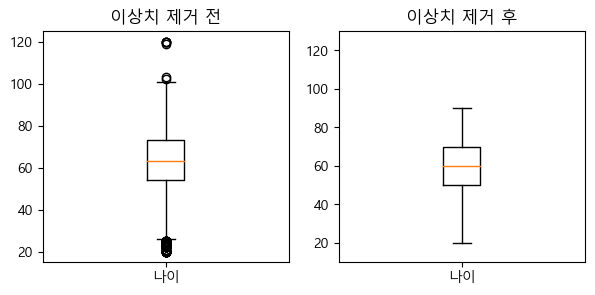

답안
"나이"컬럼에 대해서 90세 이상의 경우 90대로 변경


In [5]:
# 나이 
# result['대표나이'].plot(kind='box')
#(result['나이'] // 10 * 10).value_counts().sort_index() # 100살 이상은 90대로 처리
pre_df['나이이상치_제거'] = (pre_df['나이'] //10 *10).map(lambda x : 90 if x >=90 else x)
fig,ax = plt.subplots(1,2,figsize=(7,3))
ax[0].boxplot(pre_df['나이'])
ax[1].boxplot(pre_df['나이이상치_제거'])
ax[0].set_title('이상치 제거 전')
ax[1].set_title('이상치 제거 후')
ax[1].set_ylim(10,130)
ax[0].set_xticks([1],['나이'])
ax[1].set_xticks([1],['나이'])
plt.show()
# 추가적으로 필요하다고 생각하는 컬럼에 대해서 변경은 나름대로 판단해서 작업하시길
print('답안\n"나이"컬럼에 대해서 90세 이상의 경우 90대로 변경')

### 2-1 재계약 횟수의 중앙값을 기준으로 중앙값보다 크거나 같으면 '높음', 작으면 '낮음' 으로 재계약 횟수 이분 변수를 구성하시오.

In [6]:
med=pre_df['재계약횟수'].median()
pre_df['이분변수'] = pre_df['재계약횟수'].map(lambda x : '높음' if x >= med else '낮음')
display(pre_df['이분변수'].value_counts().to_frame())
print('답안\n중앙값은 6이다. 이를 기준으로 이분변수를 나누고 새로운 컬럼을 만든다. ')

,이분변수
높음,5388
낮음,4960


답안
중앙값은 6이다. 이를 기준으로 이분변수를 나누고 새로운 컬럼을 만든다. 


### 2-2 차원축소의 필요성을 논하고, 필요에 따라 차원을 축소하고 불필요하다면 그 근거를 논하시오.

In [7]:
p_df = pre_df.drop(columns = ['순번','아파트 이름','호실고유번호','계약자고유번호','계약서고유번호','대표나이','나이'])
p_df['월세(만원)'] = p_df['월세(원)']/10000
p_df['보증금(백만원)'] = p_df['보증금(원)']/1000000
p_df = p_df.drop(columns = ['월세(원)','보증금(원)'])

for col in p_df.select_dtypes(include= object):
    lb = LabelEncoder()
    p_df[col] = lb.fit_transform(p_df[col])
    
pca = PCA()
mm = MinMaxScaler()

pca_df = pd.DataFrame(mm.fit_transform(p_df))
pca_df.columns = p_df.columns
pca.fit(pca_df)

ratio = pd.DataFrame(pca.explained_variance_ratio_,columns =['ratio'])
ratio['cumsum'] =ratio['ratio'].cumsum()
ratio.columns = ['variance_ratio','cumsum']
ratio.index = ['PC_' + str(i+1) for i in ratio.index]

display(ratio.round(2).T)
print('답안\n순번,아파트 이름 호실 고유번호, 계약자 고유번호, 계약서 고유번호는 데이터 구분을 위한 특정 PK이기 때문에 제거한다.')
print('대표나이의 경우 2020년 기준의 나이이기 때문에 제거한다. 나이 컬럼은 이상치 제거한 컬럼이 있기 때문에 제거한다.')
print('범주형 변수에 대해서 라벨인코딩을 진행한 후 min-max 스케일링을 하고 pca를 진행한다.')
print('분산설명력의 경우 7개의 주축을 선택할 경우 92% 데이터 설명이 가능하다.')
print('전체 컬럼의 숫자가 17개로 많지 않고 데이터 설명을 위한 데이터 주축의 숫자가 많이 필요 하기 때문에 굳이 차원 축소를 하지 않겠다.')

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17
variance_ratio,0.34,0.20,0.15,0.07,0.06,0.05,0.04,0.02,0.02,0.02,0.01,0.0,0.0,0.0,0.0,0.0,0.0
cumsum,0.34,0.54,0.69,0.77,0.82,0.87,0.92,0.94,0.96,0.98,0.99,1.0,1.0,1.0,1.0,1.0,1.0


답안
순번,아파트 이름 호실 고유번호, 계약자 고유번호, 계약서 고유번호는 데이터 구분을 위한 특정 PK이기 때문에 제거한다.
대표나이의 경우 2020년 기준의 나이이기 때문에 제거한다. 나이 컬럼은 이상치 제거한 컬럼이 있기 때문에 제거한다.
범주형 변수에 대해서 라벨인코딩을 진행한 후 min-max 스케일링을 하고 pca를 진행한다.
분산설명력의 경우 7개의 주축을 선택할 경우 92% 데이터 설명이 가능하다.
전체 컬럼의 숫자가 17개로 많지 않고 데이터 설명을 위한 데이터 주축의 숫자가 많이 필요 하기 때문에 굳이 차원 축소를 하지 않겠다.


### 3-1 재계약 횟수 이분변수를 기준으로 세그먼트를 구분하고 각 세그먼트의 특징을 분석하시오.

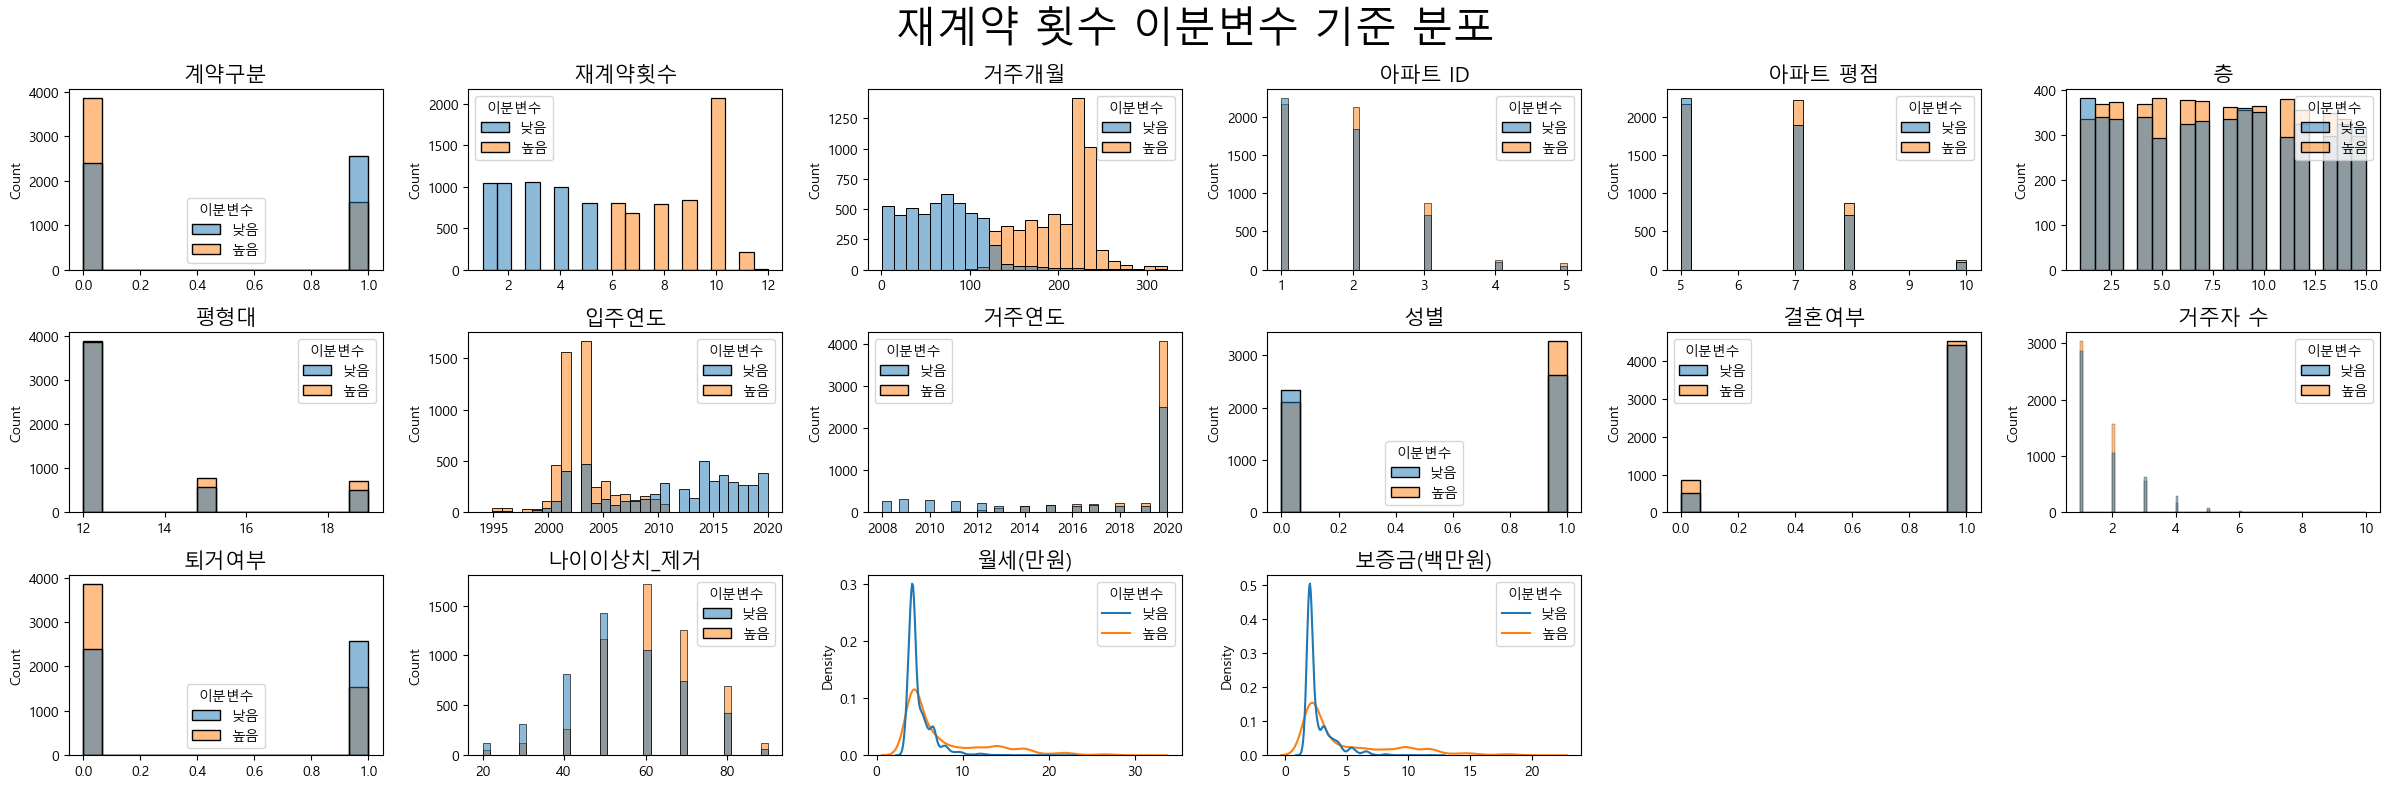

,계약구분,재계약횟수,거주개월,아파트 ID,아파트 평점,층,평형대,입주연도,거주연도,성별,결혼여부,거주자 수,퇴거여부,나이이상치_제거,월세(만원),보증금(백만원)
p-value,0.0,0.0,0.0,0.0,0.0,0.85174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


답안
이분변수를 기준으로 각 컬럼의 분포에 대한 그래프이다. 이분변수를 기준으로 큰 차이를 보이는 것은 재계약 횟수, 거주개월, 입주연도, 월세,보증금이다.
이분변수는 재계약 횟수 중앙값을 기준으로 만든것이기에 거주개월에 대해서는 어느정도 상관성을 보임을 추측 할 수 있다. 거주개월이 긴 경우는 입주연도도 길 것이다.
보증금과 월세의 경우의 경우 이분변수가 높은 경우 분산이 더 크다.
층을 제외하고는 모든 변수에서 유의 수준 0.05하에서 이분변수 간의 차이가 존재한다.
아파트 ID와 층에 따라서는 크게 이분변수의 차이가 존재하지 않는다. 나이의 경우 이분변수가 높을 경우 평균 연령이 높다


In [8]:
from scipy.stats import ttest_ind

p_value_lst = []
fig, ax = plt.subplots(3, 6, figsize=(24,8))

for i, axes in enumerate(ax.flat[:-2]):
    target_columns = p_df.drop(columns =['이분변수']).columns[i]
    target_df = p_df[[target_columns,'이분변수']]
    target_df['이분변수'] = target_df['이분변수'].map({0:'낮음',1:'높음'}) # 라벨인코딩시에 어떤 레이블링을 했는지 확인해야함

    s,pv = ttest_ind(target_df.query('이분변수 =="높음"')[target_columns],target_df.query('이분변수 =="낮음"')[target_columns])
    p_value_lst.append([target_columns,round(pv,5)])

    if '월세' not in target_columns and '보증금' not in target_columns:
        sns.histplot(data=target_df, x= target_columns, hue= '이분변수', ax = axes)
        axes.set_xlabel('')
        axes.set_title(target_columns,fontsize=15)

    else:
        sns.kdeplot(data=target_df ,x= target_columns,hue= '이분변수',ax = axes,)
        axes.set_xlabel('')
        axes.set_title(target_columns,fontsize=15)

ax.flat[-1].remove()
ax.flat[-2].remove()
fig.suptitle('재계약 횟수 이분변수 기준 분포',fontsize=30)
fig.tight_layout()
plt.show()
pv_df = pd.DataFrame(p_value_lst).set_index(0).T
pv_df.index = ['p-value']
display(pv_df)
print('답안')
print('이분변수를 기준으로 각 컬럼의 분포에 대한 그래프이다. 이분변수를 기준으로 큰 차이를 보이는 것은 재계약 횟수, 거주개월, 입주연도, 월세,보증금이다.')
print('이분변수는 재계약 횟수 중앙값을 기준으로 만든것이기에 거주개월에 대해서는 어느정도 상관성을 보임을 추측 할 수 있다. 거주개월이 긴 경우는 입주연도도 길 것이다.')
print('보증금과 월세의 경우의 경우 이분변수가 높은 경우 분산이 더 크다.')
print('층을 제외하고는 모든 변수에서 유의 수준 0.05하에서 이분변수 간의 차이가 존재한다.')
print('아파트 ID와 층에 따라서는 크게 이분변수의 차이가 존재하지 않는다. 나이의 경우 이분변수가 높을 경우 평균 연령이 높다')

### 3-2. 재계약횟수 변수를 종속변수로 하는 회귀 분석을 두 가지 이상의 방법론을 통해 수행하고 최종 모델을 결
정하시.  재계약횟수 이분변수를 종속변수로 하는 분 분분석을 두가지 이상의 방법론을 통해 수행하고 최
모델을 결정하시오.

In [9]:
preprocessing_df = p_df
preprocessing_df = preprocessing_df.rename(columns ={'이분변수':'y'})

# 스케일링 안해도되는 장점있고, 변수 중요도 확인 가능한 트리류 계열끼리 비교
# 최종 결과의 경우에도 하나의 데이터 프레임으로 정리하는게 좋지 않을까 / 다양한 모델 및 모델 최적화 과정보다 답변 깔끔하게 쓰는게 더 중요 할듯
x = preprocessing_df.drop(columns =['y','재계약횟수','거주개월','거주연도','입주연도'])
reg_y = preprocessing_df['재계약횟수']
cls_y = preprocessing_df['y']
cls_rf = RandomForestClassifier(random_state =3)
cls_dc = DecisionTreeClassifier(random_state =3)
reg_rf = RandomForestRegressor(random_state =3)
reg_dc = DecisionTreeRegressor(random_state =3)

In [10]:
models = []
score = []
feature_importance = []

classification_models = [("RF_Classifier", RandomForestClassifier(random_state=3)),
                         ("DT_Classifier", DecisionTreeClassifier(random_state=3)),]

regression_models = [("RF_Regressor", RandomForestRegressor(random_state=3)),
                     ("DT_Regressor", DecisionTreeRegressor(random_state=3))]

X_train, X_test, y_train, y_test = train_test_split(x, cls_y, test_size=.33, random_state=42)

for name, model in classification_models:
    pipe = Pipeline(steps=[#('preprocessor', StandardScaler()),
                                  ('model', model)])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, pred)
    models.append(name)
    score.append(acc)
    feature_importance.append(model.feature_importances_)
    #print(f'{name} Accuarcy score: {acc}')

X_train, X_test, y_train, y_test = train_test_split(x, reg_y, test_size=.33, random_state=42)

for name, model in regression_models:
    pipe = Pipeline(steps=[#('preprocessor', StandardScaler()),
                                  ('model', model)])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    acc = mean_squared_error(y_test, pred)
    score.append(acc)
    models.append(name)
    feature_importance.append(model.feature_importances_)
    #print(f'{name} Accuarcy score: {acc}')

result = pd.DataFrame({'model': models, 'test_accuracy': score}).set_index('model')
display(result.round(2))
print('답안\n')
print('이분변수는 재계약 횟수를 기준으로 만들었고 재계약 횟수는 거주개월과 거주연도 입주연도와 높은 상관성을 띄기에 이 컬럼들을 제거하고 모델을 생성한다.')
print('모델의 변수중요도를 확인하기 위해 트리류 모델들로 비교한다. 회귀모델과 분류 모델 각 경우 랜덤포레스트와 결정트리 모델에 대해 학습하고 결과를 비교한다.')
print('분류의 경우 정확도로 모델을 평가하고 회귀모델의 경우 평균제곱오차를 통해 모델을 비교한다. 정확도는 숫자가 클수록 좋은 모델이고')
print('mse는 그 값이 작을 수록 모델 오차가 작다고 판단 할 수 있다. 67%의 데이터로 학습하고, 33%의 모델로 평가했을 때')
print("분류, 회귀 모두 랜덤포레스트 모델이 더 좋은 성능을 가졌다.")
print('의사결정나무에 비해 랜덤포레스트 모델은 많은 앙상블 과정을 거치기에 과적합이 적어서 이런 결과가 나온것으로 보인다.')

,test_accuracy
model,
RF_Classifier,0.71
DT_Classifier,0.69
RF_Regressor,7.22
DT_Regressor,11.03


답안

이분변수는 재계약 횟수를 기준으로 만들었고 재계약 횟수는 거주개월과 거주연도 입주연도와 높은 상관성을 띄기에 이 컬럼들을 제거하고 모델을 생성한다.
모델의 변수중요도를 확인하기 위해 트리류 모델들로 비교한다. 회귀모델과 분류 모델 각 경우 랜덤포레스트와 결정트리 모델에 대해 학습하고 결과를 비교한다.
분류의 경우 정확도로 모델을 평가하고 회귀모델의 경우 평균제곱오차를 통해 모델을 비교한다. 정확도는 숫자가 클수록 좋은 모델이고
mse는 그 값이 작을 수록 모델 오차가 작다고 판단 할 수 있다. 67%의 데이터로 학습하고, 33%의 모델로 평가했을 때
분류, 회귀 모두 랜덤포레스트 모델이 더 좋은 성능을 가졌다.
의사결정나무에 비해 랜덤포레스트 모델은 많은 앙상블 과정을 거치기에 과적합이 적어서 이런 결과가 나온것으로 보인다.


### 3-3 최종 채택한 모델에서 각각 유의하게 작용하는 변수를 확인하고 설명하시오

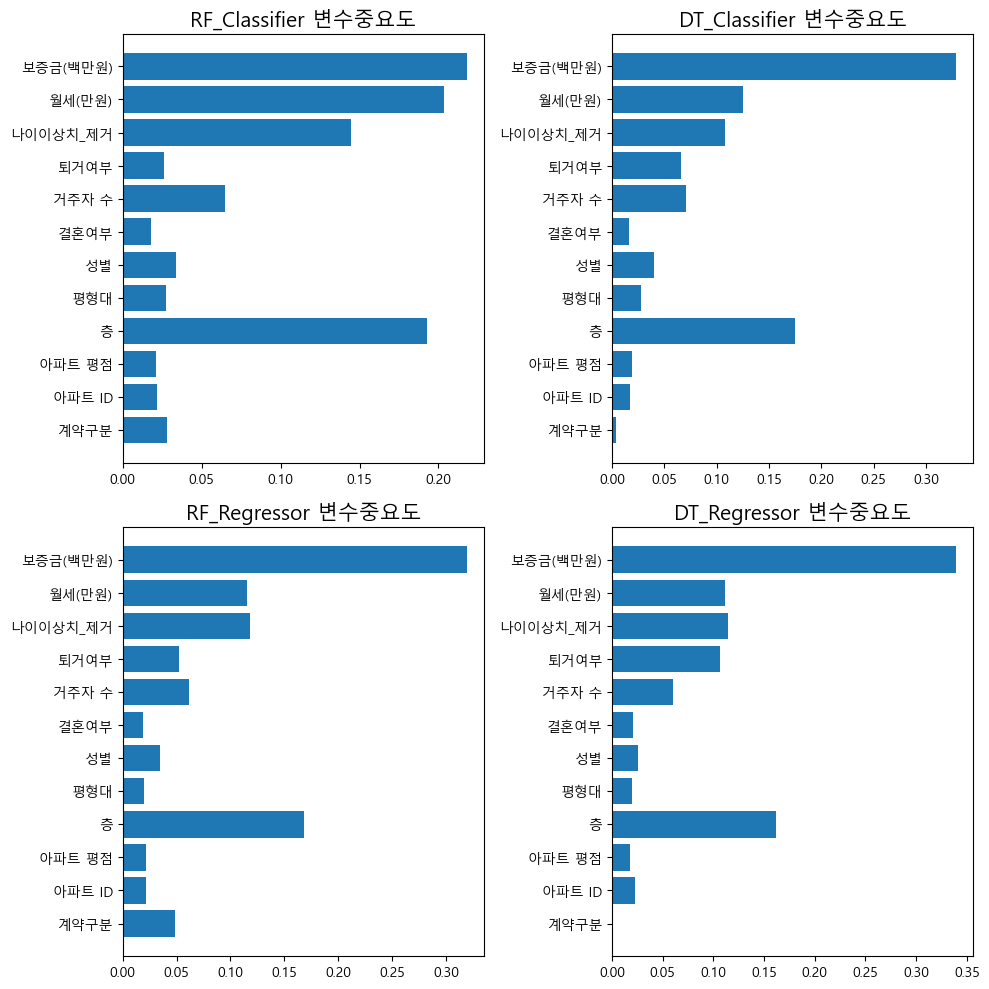

답안

분류모델의 경우 보증금, 월세, 층 순서로 중요도를 보였고
회귀 모델의 경우 보증금, 층, 나이이상치 제거 순서로 변수 중요도를 보였다


In [11]:
fig,ax = plt.subplots(2,2,figsize=(10,10))
ax[0, 0].barh(model.feature_names_in_,feature_importance[0])
ax[0, 1].barh(model.feature_names_in_,feature_importance[1])
ax[1, 0].barh(model.feature_names_in_,feature_importance[2])
ax[1, 1].barh(model.feature_names_in_,feature_importance[3])

ax[0, 0].set_title(f'{models[0]} 변수중요도',fontsize=15)
ax[0, 1].set_title(f'{models[1]} 변수중요도',fontsize=15)
ax[1, 0].set_title(f'{models[2]} 변수중요도',fontsize=15)
ax[1, 1].set_title(f'{models[3]} 변수중요도',fontsize=15)
fig.tight_layout()
plt.show()
print('답안\n')
print('분류모델의 경우 보증금, 월세, 층 순서로 중요도를 보였고')
print('회귀 모델의 경우 보증금, 층, 나이이상치 제거 순서로 변수 중요도를 보였다')

### 3-4 해당 데이터 분석결과로 얻을 수 있는 점 제시

In [12]:
r= p_df[['이분변수','월세(만원)','보증금(백만원)','나이이상치_제거','입주연도']].groupby(['이분변수']).agg(['mean']).round(2)
r.index = ['낮음','높음']
display(r)
print('재계약 횟수의 중앙값을 기준으로 세그먼트를 나눠 분석해 보았다.')
print('층수의 경우 이분변수간 통계적으로 유의한 차이를 보이지 않았지만, 모델에서는 상위 구분을 위한 중요도를 보였다.')
print('재계약 횟수가 높은 경우 월세와 보증금의 평균값이 평균 2배 높았고 대표 거주인의 나이도 있고 7살 많았다.')
# 뭔가 더 인사이트가 한두줄 더 들어가야 할 것 같습니다 ㅎㅎ;

,월세(만원),보증금(백만원),나이이상치_제거,입주연도
,mean,mean,mean,mean
낮음,4.95,2.67,54.57,2011.27
높음,7.72,4.86,61.38,2003.25


재계약 횟수의 중앙값을 기준으로 세그먼트를 나눠 분석해 보았다.
층수의 경우 이분변수간 통계적으로 유의한 차이를 보이지 않았지만, 모델에서는 상위 구분을 위한 중요도를 보였다.
재계약 횟수가 높은 경우 월세와 보증금의 평균값이 평균 2배 높았고 대표 거주인의 나이도 있고 7살 많았다.


# ADP 29회 실기 머신러닝 2

## 데이터 설명
- 데이터 출처 : https://www.kaggle.com/datasets/pschale/mlb-pitch-data-20152018 데이터를 후처리
- 데이터 링크 : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p2_.csv
- 데이터 설명 : 

A 야구구단의 시합 결과중 일부를 나타낸다.    
각 행은 하나의 경기를 의미(game_id)하며 9회차(= 9이닝) 동안 1번타자, 2번타자의 출루 정보를 의미한다.     
각 컬럼에 대한 설명은 아래 이미지와 같으며, value값의 index는 이미지의 '수치 의미' 열을 통해 확인 할 수 있다.


<img src="https://github.com/Datamanim/datarepo/blob/main/adp/29/p1_img.png?raw=true" width="500" height="600">

## 4-1 각 회차별로 1번 타자의 출루 (1,2,3루타와 사사구(볼넷, 몸에맞는공))가 있는 경우에 대해 득점이 발생 했는지 확인하고자 한다. 이를 위한 전처리를 수행하라. (단, 첫 번째 혹은 두 번째 타자가 홈런을 친 경우 해당 회차 데이터는 제외한다.)     

조건1 : 득점여부를 범주형 종속변수로 한다. (1점이상 득점 :1, 무득점 :0)     
조건2 : 각 회차 2번 타자의 데이터는 원핫 인코딩한다.    
조건3 : 학습에 적절하지 않은 데이터는 제외한다.   

- 첫째, 둘째 타자의 각 이닝별 출루현황, 해당 이님의 득점 수를 3 컬럼 데이터로 변환
- 홈런 (4) 값 가지는 행 제거
- 이닝별 점수를 binary로 변환 (득점:1, 무득점: 0)
- 둘째 타자 출루 결과를 ont-hot encoding

In [13]:
url = 'https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p2_.csv'
df = pd.read_csv(url)

In [14]:
df.head()

,game_id,a1_1,a1_2,a2_1,a2_2,a3_1,a3_2,a4_1,a4_2,a5_1,a5_2,a6_1,a6_2,a7_1,a7_2,a8_1,a8_2,a9_1,a9_2,b1,b2,b3,b4,b5,b6,b7,b8,b9
0,201900016,5,5,5,5,5,5,5,5,5,5,7,1,5,5,1,1,1,5,0,0,0,0,0,0,0,4,2
1,201900023,6,4,5,5,2,5,1,1,6,5,4,1,1,5,5,6,2,7,3,0,0,1,0,1,3,1,0
2,201900103,5,6,5,5,1,9,5,4,6,1,4,2,6,1,5,5,5,6,0,0,1,1,4,1,2,0,1
3,201900112,5,7,6,1,5,5,1,5,1,5,5,5,6,7,6,9,5,5,0,3,0,0,0,0,1,0,0
4,201900131,5,1,2,5,2,5,7,2,6,6,5,1,5,5,6,5,6,6,0,2,4,1,2,2,0,1,0


In [17]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p2_.csv')

lst = []
for i in range(1,10):
    each_innings_df = df[['game_id',f'a{i}_1',f'a{i}_2',f'b{i}']].reset_index(drop=True)
    each_innings_df.columns =['game_id','first_hitter','second_hitter','inning_score']
    each_innings_df.loc[:,'inning'] = i
    lst.append(each_innings_df)
    
t = pd.concat(lst).reset_index(drop=True)
tt = t[t.first_hitter.map(lambda x : str(x).isdigit())].reset_index(drop=True)
tt.first_hitter =tt.first_hitter.astype('int')
tt.second_hitter =tt.second_hitter.astype('int')

tts = tt[(tt.first_hitter != 4) & (tt.second_hitter != 4)].reset_index(drop=True)
tts.inning_score =tts.inning_score.map(lambda x : 1 if x >0 else 0)

sec = pd.get_dummies(tts.second_hitter.astype('str'))
sec.columns = ['second_hitter_' + str(x) for x in sec.columns]

g = pd.concat([tts[['game_id','first_hitter','inning_score','inning']],sec],axis=1)
result= g[['game_id','inning', 'first_hitter', 'second_hitter_1','second_hitter_2', 'second_hitter_3', 'second_hitter_5','second_hitter_6', 'second_hitter_7', 'second_hitter_8','second_hitter_9','inning_score']]
result['first_hitter'] = result['first_hitter'].map(lambda x : 1 if x in [1,2,3,6,8] else 0 )
result.head()

,game_id,inning,first_hitter,second_hitter_1,second_hitter_2,second_hitter_3,second_hitter_5,second_hitter_6,second_hitter_7,second_hitter_8,second_hitter_9,inning_score
0,201900016,1,0,0,0,0,1,0,0,0,0,0
1,201900103,1,0,0,0,0,0,1,0,0,0,0
2,201900112,1,0,0,0,0,0,0,1,0,0,0
3,201900131,1,0,1,0,0,0,0,0,0,0,0
4,201900141,1,1,0,0,0,1,0,0,0,0,0


### 4-2 4-1 데이터에 대해 Logistic Regression을 적용하고 2번타자의 희생번트 여부에 대한 회귀 계수 검정라

In [18]:
x = result.drop(columns =['game_id','inning_score','inning'])
y = result['inning_score']

import statsmodels.api as sm
model = sm.Logit(y,x)
res = model.fit(disp=False)
display(res.summary().tables[1])
print('답안\n2번타자의 희생번트의 경우 second_hitter_9 컬럼의 p-value를 보면된다. 이는 0으로 유의수준 0.05하에서 귀무가설을 기각한다.')
print('즉 해당 변수는 종속 변수에 영향을 준다')

,coef,std err,z,P>|z|,[0.025,0.975]
first_hitter,1.8849,0.138,13.618,0.000,1.614,2.156
second_hitter_1,-0.5886,0.146,-4.019,0.000,-0.876,-0.302
second_hitter_2,0.2610,0.251,1.041,0.298,-0.230,0.753
second_hitter_3,2.0157,1.061,1.900,0.057,-0.064,4.095
second_hitter_5,-2.0612,0.122,-16.887,0.000,-2.300,-1.822
second_hitter_6,-0.6097,0.200,-3.047,0.002,-1.002,-0.218
second_hitter_7,-2.5450,0.181,-14.095,0.000,-2.899,-2.191
second_hitter_8,-0.4915,0.579,-0.849,0.396,-1.626,0.643
second_hitter_9,-0.9835,0.273,-3.607,0.000,-1.518,-0.449


답안
2번타자의 희생번트의 경우 second_hitter_9 컬럼의 p-value를 보면된다. 이는 0으로 유의수준 0.05하에서 귀무가설을 기각한다.
즉 해당 변수는 종속 변수에 영향을 준다


### 4-3 SMOTE (random_state=0 지정)를 적용하여 data imbalance를 해결하라

In [21]:
smote = SMOTE(sampling_strategy='auto', random_state=0)
X_resampled, y_resampled = smote.fit_resample(x, y)

result = pd.concat([y.value_counts(),y_resampled.value_counts()],axis=1)
result.columns = ['smote 이전 데이터 분포','smote 이후 데이터 분포']
result.index = ['레이블 0 ','레이블 1']
display(result)
print('풀이\nsmote를 통해 레이블 1의 숫자에 맞췄다.')

,smote 이전 데이터 분포,smote 이후 데이터 분포
레이블 0,1096,1096
레이블 1,511,1096


풀이
smote를 통해 레이블 1의 숫자에 맞췄다.


### 4-4 4-3 구성 데이터에 Logistic Regression을 적용하고 결과를 분석하라

In [22]:
# 문제 표현에 따라 다르게 접근 할듯 / 4-2와의 비교 or 그냥 분류 모델 결과 확인
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=1,stratify=y_resampled)
model = sm.Logit(y_train.reset_index(drop=True), X_train.reset_index(drop=True))   
result = model.fit(disp=False)   
display(res.summary().tables[1])
acc =accuracy_score(y_test.reset_index(drop=True),result.predict(X_test).map(lambda x : 1 if x>=0.5 else 0))
print('정확도 : ',acc)

,coef,std err,z,P>|z|,[0.025,0.975]
first_hitter,1.8849,0.138,13.618,0.000,1.614,2.156
second_hitter_1,-0.5886,0.146,-4.019,0.000,-0.876,-0.302
second_hitter_2,0.2610,0.251,1.041,0.298,-0.230,0.753
second_hitter_3,2.0157,1.061,1.900,0.057,-0.064,4.095
second_hitter_5,-2.0612,0.122,-16.887,0.000,-2.300,-1.822
second_hitter_6,-0.6097,0.200,-3.047,0.002,-1.002,-0.218
second_hitter_7,-2.5450,0.181,-14.095,0.000,-2.899,-2.191
second_hitter_8,-0.4915,0.579,-0.849,0.396,-1.626,0.643
second_hitter_9,-0.9835,0.273,-3.607,0.000,-1.518,-0.449


정확도 :  0.712707182320442


### 4-5 4-3 구성 데이터에 XGB를 적용하고 결과를 분석하라

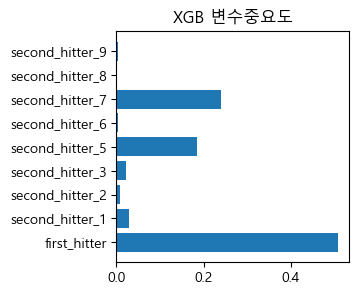

정확도는 69.6 % 이다.
첫번쨰 타자의 출루가 가장큰 변수 중요도를 가지며 그다음으로 2번째 타자의 삼진과 그외 아웃들이 순서를 따른다


In [23]:
model = xgb.XGBClassifier( random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

plt.figure(figsize=(3,3))
plt.barh(model.feature_names_in_,model.feature_importances_)
plt.title('XGB 변수중요도')
plt.show()
print("정확도는", round(accuracy*100,1),'% 이다.\n첫번쨰 타자의 출루가 가장큰 변수 중요도를 가지며 그다음으로 2번째 타자의 삼진과 그외 아웃들이 순서를 따른다')

# ADP_ML_28

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from IPython.display import display , HTML
display(HTML("<style>.container {width :95% !important;}</style>"))

from scipy.stats import chi2_contingency
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE


from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score , classification_report

import warnings 
warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier


import time
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from scipy.stats import mannwhitneyu
import pingouin as pg

## 데이터 설명
- 데이터 출처 : https://www.kaggle.com/datasets/dipam7/student-grade-prediction?resource=download 후처리
- 데이터 링크 : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p1.csv
- 데이터 설명 : 학생의 다양한 주변 환경에 따른 결석 등급 (absences)
    - sex : 성별 (F : 여성 / M :남성)
    - age : 나이
    - pstatus : 부모와 동거 유무 (T : 동거중 , A : 별거)
    - medu : 어머니 교육(0 - 없음, 1 - 초등 교육(4학년), 2 - 5~9학년, 3 - 중등 교육 또는 4 - 고등 교육)
    - fedu : 아버지 교육(0 - 없음, 1 - 초등 교육(4학년), 2 - 5 - 9학년, 3 - 중등 교육 또는 4 - 고등 교육)
    - guardian : 학생의 보호자
    - traveltime : 집에서 학교까지 이동 시간(1 - <15분, 2 - 15 - 30분, 3 - 30분 - 1시간, 또는 4 - >1시간)
    - studytime : 주간 학습 시간(1 - <2시간, 2 - 2 - 5시간, 3 - 5 - 10시간 또는 4 - >10시간)
    - failures : 과거 클래스 실패 수(n if 1<=n<3, 그렇지 않으면 4)
    - freetime : 방과 후 자유 시간(숫자: 1 - 매우 낮음에서 5 - 매우 높음)
    - famrel : 가족 관계의 질(숫자: 1 - 매우 나쁨에서 5 - 훌륭함)
    - absences : 학교 결석 횟수등급 (0~5, 높은 숫자일수록 많은 결석 횟수)숫자일수록 많은 결석 횟수)

In [45]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p1.csv")
df.head()

,sex,age,pstatus,medu,fedu,guardian,traveltime,studytime,failures,freetime,famrel,absences
0,F,18,A,4,4,mother,2,2,0,3,4,2
1,F,17,T,1,1,father,1,2,0,3,5,1
2,F,15,T,1,1,mother,1,2,3,3,4,3
3,F,15,T,4,2,mother,1,3,0,2,3,0
4,F,16,T,3,3,father,1,2,0,3,4,1


## 1-1. EDA를 진행하고 (+시각화) , 차원축소의 필요성이 있는지 확인 (5점)

컬럼명,sex,pstatus,medu,fedu,guardian,traveltime,studytime,failures,freetime,famrel
카이제곱 독립성검정 p-value,0.793048,0.019316,0.451756,0.673619,0.015805,0.834993,0.044393,0.005994,0.483288,0.840443


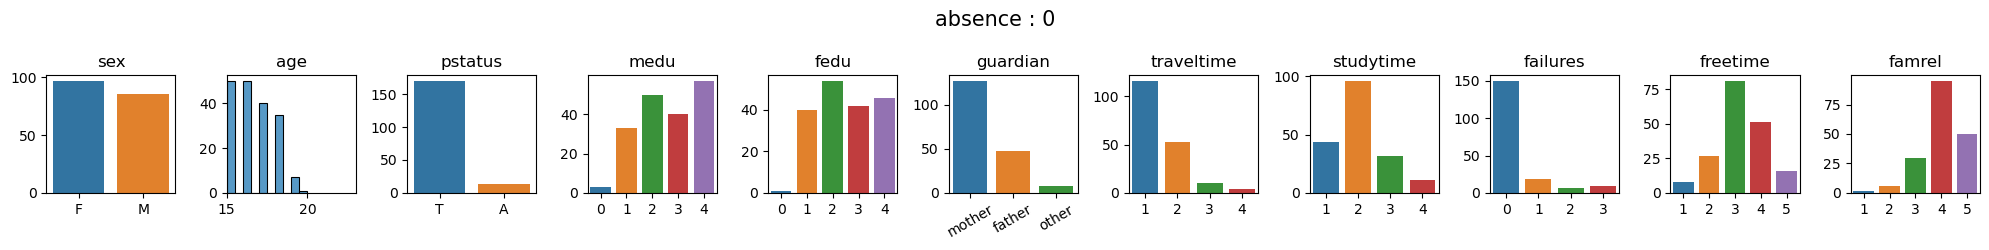

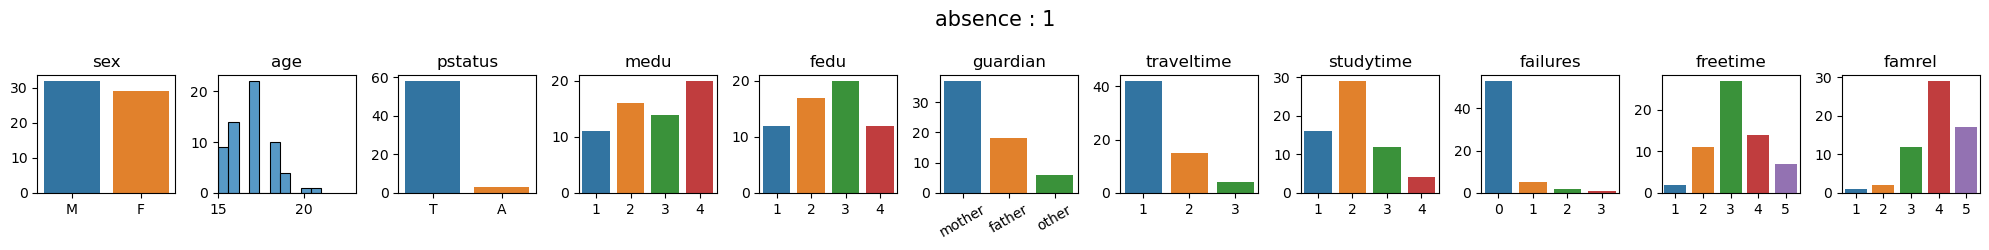

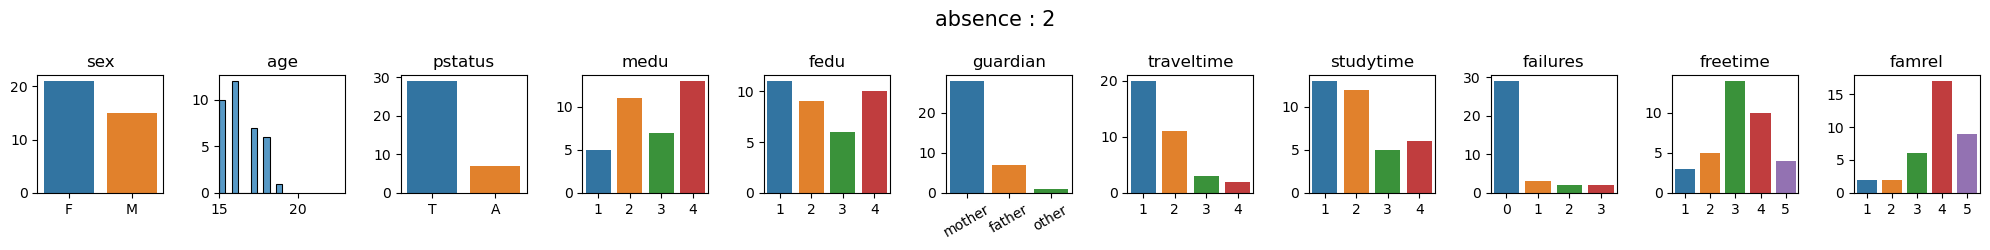

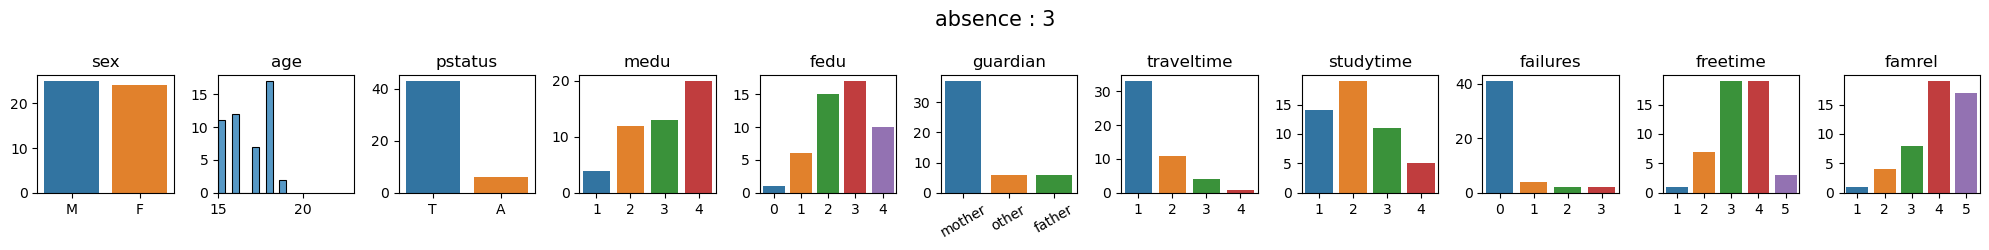

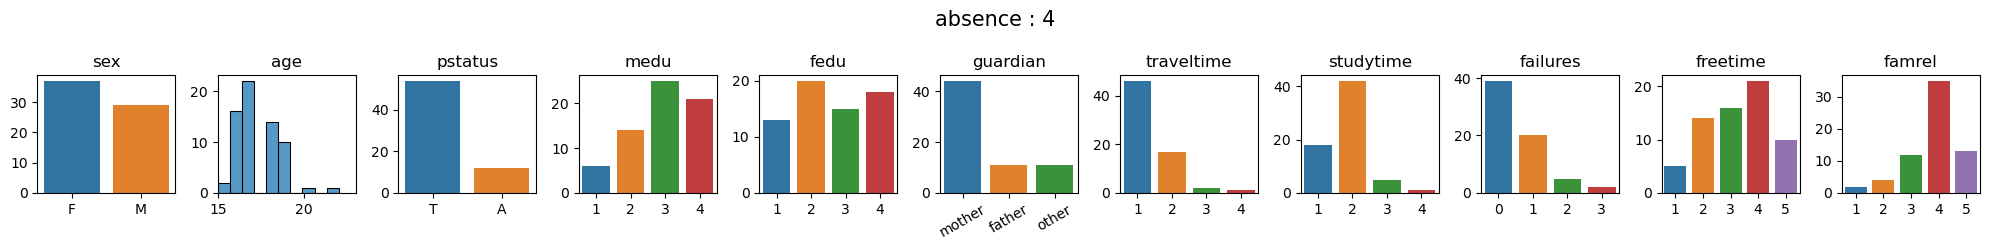

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,pc_11,pc_12,pc_13
분산설명력,0.209782,0.190134,0.130152,0.106455,0.069152,0.055187,0.052656,0.043011,0.039200,0.035506,0.030513,0.020161,0.018092
누적합,0.209782,0.399916,0.530068,0.636523,0.705675,0.760862,0.813518,0.856529,0.895728,0.931234,0.961747,0.981908,1.000000



답안
위 그래프는 absence의 값에 따른 각 컬럼의 데이터 분포를 나타낸다. 각 컬럼의 유니크 값의 개수는 레이블에 따라 시각적으로는 눈에 띄는 차이를 보이지 않는다.
연속형 변수인 age컬럼을 제외하고 각컬럼들을 absences와 카이제곱 독립성 검정을 했을 때, pstatus,guardian,studytime,failures 컬럼에서
유의수준 0.05하에서 변수간에 유의한 관계를 가짐을 알 수 있다.
범주형 변수 중 string형식으로 된 변수들을 더미변수 처리하고 minmax스케일링 후 pca를 진행했다. 분산설명력이 7개컬럼은 있어야 80%를 넘는다.
데이터 숫자도 작고 주성분들의 분산설명력이 그다지 높지 않기 떄문에 차원축소의 필요성이 떨어진다고 볼 수 있다.



In [86]:
lst = [] 
for col in df.columns[:-1]: # absences (label 컬럼 제외)
    
    if col != 'age': # only for categorical columns
        cross_tab_df = pd.crosstab(df[col],df['absences'])
        chi2, p, dof, expected = chi2_contingency(cross_tab_df)
        lst.append([col,p])
    
display(pd.DataFrame(lst,columns =['컬럼명','카이제곱 독립성검정 p-value']).set_index('컬럼명').T)

n_plt_columns = len(df.columns) -1 # absences 컬럼 제외
for absences in sorted(df['absences'].unique()):
    
    fig,axes = plt.subplots(1,n_plt_columns,figsize=(20,2.5))
    
    for col , ax in zip(df.columns[:-1],axes.flat):
        
        target_df = df.query(f"absences =={absences}")[col] # sns.histplot(df.query('absences == 0')['age'])
        if col =='age': # age(int) 는 histogram
            sns.histplot(target_df,ax=ax,bins=10)
            ax.set_ylabel('')
            ax.set_xlabel('')
            ax.set_title(col)
            ax.set_xlim(df[col].min(),df[col].max()+1)

        else: #
            df_value_counts = target_df.value_counts().to_frame()
            sns.barplot(x = df_value_counts.index , y = df_value_counts[col], ax=ax) # df.query('absences == 0')['sex'].value_counts()
            ax.set_ylabel('')
            ax.set_xlabel('')
            ax.set_title(col)
            
            if col =='guardian':
                ax.set_xticklabels( df_value_counts.index, rotation=30)
                
    plt.suptitle(f"absence : {absences}",fontsize=15)
    fig.tight_layout()
    plt.show()

pca = PCA()
df_dummies = pd.get_dummies(df,drop_first=True)
pca_df_scaled = MinMaxScaler().fit_transform(df_dummies)

pca.fit(pca_df_scaled)
pca_ex_v = pd.DataFrame(pca.explained_variance_ratio_,columns =['분산설명력'])
pca_ex_v['누적합'] = pca_ex_v['분산설명력'].cumsum()
pca_ex_v.index = ['pc_'+str(i+1) for i in range(len(pca_ex_v))]
display(pca_ex_v.T)

print('''
답안\n위 그래프는 absence의 값에 따른 각 컬럼의 데이터 분포를 나타낸다. 각 컬럼의 유니크 값의 개수는 레이블에 따라 시각적으로는 눈에 띄는 차이를 보이지 않는다.
연속형 변수인 age컬럼을 제외하고 각컬럼들을 absences와 카이제곱 독립성 검정을 했을 때, pstatus,guardian,studytime,failures 컬럼에서
유의수준 0.05하에서 변수간에 유의한 관계를 가짐을 알 수 있다.
범주형 변수 중 string형식으로 된 변수들을 더미변수 처리하고 minmax스케일링 후 pca를 진행했다. 분산설명력이 7개컬럼은 있어야 80%를 넘는다.
데이터 숫자도 작고 주성분들의 분산설명력이 그다지 높지 않기 떄문에 차원축소의 필요성이 떨어진다고 볼 수 있다.
''')

## 1-2. 데이터 품질 개선을 위한 방법이 있는지 찾고 데이터셋을 재생성하라 (5점)

In [87]:
x = df_dummies.drop(columns =['absences'])
y = df_dummies['absences']

smote = SMOTE(random_state =1)
x_resample, y_resample = smote.fit_resample(x,y)

t = pd.concat([y.value_counts().sort_index(),y_resample.value_counts().sort_index()],axis=1)
t.columns =['기존 샘플수','smote 후 샘플수']
t.index.name ='라벨'
display(t.T)
print('''
종속변수의 데이터 불균형이 있다. 이를 해결하기 위해 smote방식을 이용하여 오버샘플링을 진행한다.
''')

라벨,0,1,2,3,4
기존 샘플수,183,61,36,49,66
smote 후 샘플수,183,183,183,183,183



종속변수의 데이터 불균형이 있다. 이를 해결하기 위해 smote방식을 이용하여 오버샘플링을 진행한다.



## 1-3. 1.2에서 제시한 방법이 데이터 과적합이 된다는 가정하에 어떻게 해결할 수 있을지 2가지 개선안 제시, 각방법들의 장단점 기술 (10점)

In [88]:
print('''
방법1\n 스케일링을 다양하게 시도하며 오버 샘플링을 진행한다. 데이터 특성을 반영할 수 있기에 장점이 된다. 
방법2\n 과적합 되는 레이블에 대해서 오버 샘플링 된 데이터들의 숫자를 조절한다. 
''')


방법1
 스케일링을 다양하게 시도하며 오버 샘플링을 진행한다. 데이터 특성을 반영할 수 있기에 장점이 된다. 
방법2
 과적합 되는 레이블에 대해서 오버 샘플링 된 데이터들의 숫자를 조절한다. 



## 2-1. 1-2 데이터셋을 기준으로 random forest, neural network , lightgbm 3가지 방식으로 학교 결석 횟수등급을 예측하는 모델을 만들어라, f1 score로 모델을 평가하라 (5점)

In [89]:
rf = RandomForestClassifier(random_state=1)
nn = MLPClassifier(random_state=1)
lgbm =LGBMClassifier(random_state=1)

x_train,x_test,y_train,y_test = train_test_split(x_resample,y_resample,random_state=1,test_size=0.3)

rf.fit(x_train,y_train)
nn.fit(x_train,y_train)
lgbm.fit(x_train,y_train,verbose=2)

rf_pred = rf.predict(x_test)
nn_pred = nn.predict(x_test)
lgbm_pred = lgbm.predict(x_test)

def f1_filter(y_test,y_pred,name):
    macro = f1_score(y_test,y_pred,average='macro')
    micro = f1_score(y_test,y_pred,average='micro')
    weighted = f1_score(y_test,y_pred,average='weighted')
    
    return pd.DataFrame([macro,micro,weighted],columns =[name],index=['macro','micro','weighted'])


rf_f1 = f1_filter(y_test,rf_pred,'랜덤포레스트')
nn_f1 = f1_filter(y_test,nn_pred,'뉴럴넷')
lgbm_f1 = f1_filter(y_test,lgbm_pred,'lightgbm')

t = pd.concat([rf_f1,nn_f1,lgbm_f1],axis=1)
t.index.name = 'f1_score'
display(t)

print('''
train,test셋의 비율을 7:3으로 하고 3개 모델에 대해 각각 학습하고 f1 score를 나타난 결과이다.
다중분류의 경우 f1 score는 3가지 방식(macro , micro ,weighted)으로 평가할 수 있다.
f1 score는 최대 1의 값을 가지기에 3가지 모델 모두 낮은 예측력을 가진다고 볼 수 있다.
랜덤포레스트와 lgbm의 경우 뉴럴넷에 비해 높은 f1 score를 보이는데 앙상블 방식의 모델이
스케일링 하지 않은 데이터에 대해서도 좋은 성능을 보이기 때문이다.
3가지 방식에 대한 평가 점수간의 차이가 크지 않은 이유는 smote를 통해 클래스간 분포가 큰 차이가 없기 때문이다.
클래스 간 불균형이 심한 경우 micro방식은 작은 클래스의 성능이 무시될 수 있고, micro방식은 큰 클래스가 평균에 미치는 영향이 더 크게 나타날 수 있으며
weighted방식은 작은 클래스의 성능이 무시될 수 있다.
''')

,랜덤포레스트,뉴럴넷,lightgbm
f1_score,,,
macro,0.679296,0.392061,0.642884
micro,0.687273,0.400000,0.640000
weighted,0.679030,0.389792,0.642862



train,test셋의 비율을 7:3으로 하고 3개 모델에 대해 각각 학습하고 f1 score를 나타난 결과이다.
다중분류의 경우 f1 score는 3가지 방식(macro , micro ,weighted)으로 평가할 수 있다.
f1 score는 최대 1의 값을 가지기에 3가지 모델 모두 낮은 예측력을 가진다고 볼 수 있다.
랜덤포레스트와 lgbm의 경우 뉴럴넷에 비해 높은 f1 score를 보이는데 앙상블 방식의 모델이
스케일링 하지 않은 데이터에 대해서도 좋은 성능을 보이기 때문이다.
3가지 방식에 대한 평가 점수간의 차이가 크지 않은 이유는 smote를 통해 클래스간 분포가 큰 차이가 없기 때문이다.
클래스 간 불균형이 심한 경우 micro방식은 작은 클래스의 성능이 무시될 수 있고, micro방식은 큰 클래스가 평균에 미치는 영향이 더 크게 나타날 수 있으며
weighted방식은 작은 클래스의 성능이 무시될 수 있다.



## 2-2. hard voting, soft voting에 대한 장단점을 설명하고 2-1의 3가지 모델로 구현하라. 두 방식의 f1-score를 비교하라 (10점)

In [90]:
rf_v = RandomForestClassifier(random_state=1)
nn_v = MLPClassifier(random_state=1)
lgbm_v =LGBMClassifier(random_state=1)

soft_v = VotingClassifier(estimators=[('rf', rf_v), ('nn', nn_v), ('lgbm', lgbm_v)], voting='soft')
hard_v = VotingClassifier(estimators=[('rf', rf_v), ('nn', nn_v), ('lgbm', lgbm_v)], voting='hard')

hard_v.fit(x_train,y_train)
soft_v.fit(x_train,y_train)

hard_v_pred = hard_v.predict(x_test)
soft_v_pred = soft_v.predict(x_test)


def f1_filter(y_test,y_pred,name):
    macro = f1_score(y_test,y_pred,average='macro')
    micro = f1_score(y_test,y_pred,average='micro')
    weighted = f1_score(y_test,y_pred,average='weighted')
    return pd.DataFrame([macro,micro,weighted],columns =[name],index=['macro','micro','weighted'])


soft_v1 = f1_filter(y_test,hard_v_pred,'hard_voting')
hard_v1 = f1_filter(y_test,soft_v_pred,'soft_voting')

t = pd.concat([soft_v1,hard_v1],axis=1)
t.index.name = 'f1_score'
display(t)

print('''
하드보팅과 소프트 보팅방식으로 f1 score를 계산했을 때 결과를 보여준다 개별모델들 중 최고 성능을 낸 랜덤포레스트 보다는 예측력이 낮지만
좀 더 일반화가 가능하다는 장점이 있다. 하드보팅보다는 확률 평균 방식의 소프트보팅이 f1 score가 높게 나왔다.
두 방식 모두 앙상블 방법으로 성능향상과 모델 일반화를 기대할 수 있다.
하드보팅은 모델들의 결과에 대한 다수결로 최종 예측을 하고 소프트보팅은 개별 모델의 예측확률에 대해 가중평균을 내서 최종 예측을 수행한다.
하드보팅은 직관적이고 간단한 장점이 있지만 성능을 높이는데 한계가 존재한다. 
소프트보팅의 방식의 경우 개별모델의 확률정보를 반영한다는 장점이 있다. 단점은 예측 방식이 확률을 내뱉지 않은 모델을 사용할 수 없다는 점이 있다.
''')

,hard_voting,soft_voting
f1_score,,
macro,0.660848,0.676205
micro,0.658182,0.676364
weighted,0.660790,0.675944



하드보팅과 소프트 보팅방식으로 f1 score를 계산했을 때 결과를 보여준다 개별모델들 중 최고 성능을 낸 랜덤포레스트 보다는 예측력이 낮지만
좀 더 일반화가 가능하다는 장점이 있다. 하드보팅보다는 확률 평균 방식의 소프트보팅이 f1 score가 높게 나왔다.
두 방식 모두 앙상블 방법으로 성능향상과 모델 일반화를 기대할 수 있다.
하드보팅은 모델들의 결과에 대한 다수결로 최종 예측을 하고 소프트보팅은 개별 모델의 예측확률에 대해 가중평균을 내서 최종 예측을 수행한다.
하드보팅은 직관적이고 간단한 장점이 있지만 성능을 높이는데 한계가 존재한다. 
소프트보팅의 방식의 경우 개별모델의 확률정보를 반영한다는 장점이 있다. 단점은 예측 방식이 확률을 내뱉지 않은 모델을 사용할 수 없다는 점이 있다.



## 2-3. 총 5개 모델(RF, NN, LGBM, 하드보팅, 소프트보팅) 중 실시간 온라인 시스템에 가장 적합한 모델과 선정이유를 객관적으로 제시하라 (5점)

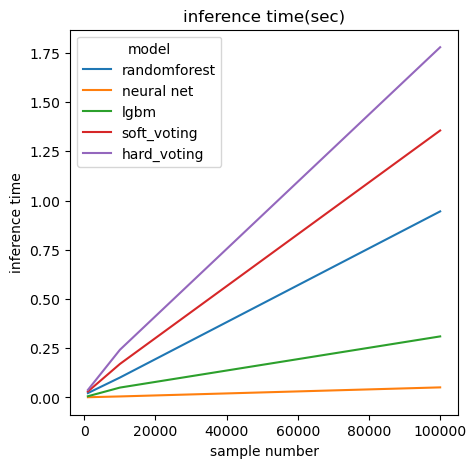


아래 그래프는 샘플수에 따른 각 모델별 모델추론 시간에 대한 그래프이다. 모델 수에 따라
추론시간이 선형적으로 증가하는 것을 확인 할 수 있다. 실시간 온라인 시스템에서 관심을 가지는것이
성능인지 빠른 추론시간인지에 따라 선택 방향이 달라질 것 이다.
보팅 방식의 경우 3가지 모델을 모두 추론해야하기 때문에 그 시간이 선형 합으로 증가한다.
성능의 경우 랜덤포레스트가 가장 좋았지만 추론시간이 lgbm보다 3배이상 크다.
시스템의 핵심 요구사항에 따라 랜덤포레스트와 lgbm중에 선택하는 것이 옳다



In [91]:
def sample_generate(n):
    sp =x_resample.sample(n,replace=True)
    return sp


def count_predict_times(model,data):
    
    start = time.time()
    model.predict(data)
    end = time.time()
    
    inference_time = end - start
    return inference_time

lst = []
for model,name in [(rf,'randomforest'),(nn,'neural net'),(lgbm,'lgbm'),(soft_v,'soft_voting'),(hard_v,'hard_voting')]:
    for sample_number in [1000,10000,100000]:
        inference_time = count_predict_times(model,sample_generate(sample_number))
        lst.append([name,sample_number,inference_time])
        
t= pd.DataFrame(lst,columns =['model','sample number','inference time'])
tp = t.pivot_table(index='model',columns ='sample number',values ='inference time')

fig,ax = plt.subplots(1,figsize=(5,5))
sns.lineplot(data =t , x = 'sample number',y= 'inference time',hue='model',ax=ax)
plt.title('inference time(sec)')
plt.show()
print('''
아래 그래프는 샘플수에 따른 각 모델별 모델추론 시간에 대한 그래프이다. 모델 수에 따라
추론시간이 선형적으로 증가하는 것을 확인 할 수 있다. 실시간 온라인 시스템에서 관심을 가지는것이
성능인지 빠른 추론시간인지에 따라 선택 방향이 달라질 것 이다.
보팅 방식의 경우 3가지 모델을 모두 추론해야하기 때문에 그 시간이 선형 합으로 증가한다.
성능의 경우 랜덤포레스트가 가장 좋았지만 추론시간이 lgbm보다 3배이상 크다.
시스템의 핵심 요구사항에 따라 랜덤포레스트와 lgbm중에 선택하는 것이 옳다
''')

## 3-1. 적정 모델과 선정 및 모델링 과정에서 추가적으로 고려해볼 만한 사항은? (5점)

모델을 api 형식으로 제공할때 모델의 용량에 따라 추론시간 및 유지비용이 달라 질 수 있다.     
큰 용량의 모델이라면 백앤드 시스템에서 모델을 import 하고 유지 하는데 비용이 달라진다.       
프로젝트의 규모와 자원등을 고려하여 적합한 모델을 설계한다.    

## 3-2. 모델을 학교 시스템에 적용하여 활용하려한다. 모델 적용 및 운영과정에서 고려해볼 만한 사항? (5점)

데이터가 누적됨에 따라 모델을 업데이트 해야하는 경우가 생길 수 있다. 새롭게 저장될 데이터 인프라를 잘 갖춰 긴밀한 업데이트를 해주는게    
모델 정확도를 높히는데 도움이 될 수 있다. 또한 covid상황과 같은 기존 모델의 상황에서는 학습하지 못한 상황이 오는 경우     
모델 효용이 떨어질 수 있다. 이런 경우에는 서비스를 중단하고 대응 모델을 적용할 수 있도록 서비스 구조를 만들어야 할 것 이다.     

### ADP_ML_24

In [114]:
from IPython.display import display,HTML
display(HTML("<style>.container {width:95% !important;}</style>"))
import pandas as pd
pd.set_option('display.max_columns',200)

import matplotlib.pyplot as plt
import seaborn as sns


from scipy import stats


#modeling

from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm


#
import warnings 
warnings.filterwarnings('ignore')

# ADP_ML_25

In [121]:
import scipy.stats as stats
import math
from scipy.stats import kruskal
import pandas as pd


from IPython.display import display,HTML

display(HTML("<style>.container {width :95% !important ;}</style>"))


from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


import seaborn as sns
sns.set_context('talk')

from sklearn.metrics import pairwise_distances_argmin_min ,r2_score
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima

# ADP 25회 실기 문제

```{admonition} 1번
**데이터 확인 및 전처리**     
- 1.1 EDA, 이상치 제거 후 F(소비자별 구매빈도), M(소비자별 총 구매액) feature를 새로 생성해서 그 결과값으로 탐색적 분석 실시
- 1.2 F, M feature 기반으로 군집분석 실시
- 1.3 군집 결과의 적합성을 군집 내 응집도, 군집 간 분리도의 개념을 사용해서 서술
- 1.4 적합된 군집 별 특성에 대한 의견과 비즈니스적 판단 제시
- 데이터 설명
    - InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.     
    - StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.     
    - Description: Product (item) name. Nominal.    
    - Quantity: The quantities of each product (item) per transaction. Numeric.     
    - InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.   
    - UnitPrice: Unit price. Numeric, Product price per unit in sterling.    
    - CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.     
    - Country: Country name. Nominal, the name of the country where each customer resides.   
- 출처
    - https://archive.ics.uci.edu/ml/index.phpm
```
송장 번호: 송장 번호입니다. 명목상, 각 트랜잭션에 고유하게 할당된 6자리 정수. 이 코드가 문자 'c'로 시작하면 취소를 나타냅니다.
StockCode: 제품(항목) 코드입니다. 각 개별 제품에 고유하게 할당된 명목상의 5자리 정수입니다.
설명: 제품(항목) 이름입니다. 명사 같은.
수량: 거래당 각 제품(항목)의 수량입니다. 숫자.
InvoiceDate: 송장 날짜 및 시간. 숫자, 각 트랜잭션이 생성된 날짜와 시간입니다.
단가: 단가. 숫자, 단위당 제품 가격(스털링 단위).
고객 ID: 고객 번호입니다. 명목상, 각 고객에게 고유하게 할당된 5자리 정수.
국가: 국가 이름입니다. 명목상, 각 고객이 거주하는 국가의 이름.

In [122]:
import pandas as pd

df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/25/problem1.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,565857,84879,ASSORTED COLOUR BIRD ORNAMENT,16,9/7/2011 14:13,1.69,14911.0,EIRE
1,560452,22432,WATERING CAN PINK BUNNY,6,7/19/2011 9:51,1.95,12682.0,France
2,578509,22492,MINI PAINT SET VINTAGE,36,11/24/2011 13:17,0.65,12705.0,Germany
3,579345,22728,ALARM CLOCK BAKELIKE PINK,8,11/29/2011 11:46,3.75,12727.0,France
4,564039,21731,RED TOADSTOOL LED NIGHT LIGHT,12,8/22/2011 12:40,1.65,12645.0,Germany


,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
InvoiceDate,2115,2948,2017,3093,1499,2932,3219,2750,3583,4333,5517,5542,1461



UnitPrice값이 0인 경우가 존재한다. 제품금액이 0 원인 경우는 이상치로 보고 제거한다.
데이터의 경우 2010년 12월 부터 2011년 12월까지 13개월동안의 데이터이다. 전체기간을 2구간으로 나누어 각각에 대해 고객별 F와 M관련 변수들을 추출한다.
F의 경우 두 구간의 기간별 총 구매 빈도와 총 취소빈도를 만든다. 
M의 경우 두 구간의 기간별 평균 구매량과 평균 구매금액에 대한 데이터를 구한다.
최종적인 데이터는 아래와 같다.



,F_price_order_dum_0,F_price_order_dum_1,F_price_cancel_dum_0,F_price_cancel_dum_1,M_mean_quantity_dum_0,M_mean_quantity_dum_1,M_mean_price_dum_0,M_mean_price_dum_1
CustomerID,,,,,,,,
12348.0,28.0,3.0,0.0,0.0,75.857143,72.333333,53.115714,103.333333
12349.0,0.0,73.0,0.0,0.0,0.000000,8.643836,0.000000,24.076027
12350.0,17.0,0.0,0.0,0.0,11.588235,0.000000,19.670588,0.000000
12352.0,38.0,47.0,10.0,0.0,6.684211,6.000000,41.100263,20.090000
12354.0,58.0,0.0,0.0,0.0,9.137931,0.000000,18.610345,0.000000



생성된 피쳐 데이터의 boxplot을 찍어보면 첫번째와 두번째 컬럼에서 이상치들이 보인다. 95% 백분위이상인 데이터를 걸러낸다. 



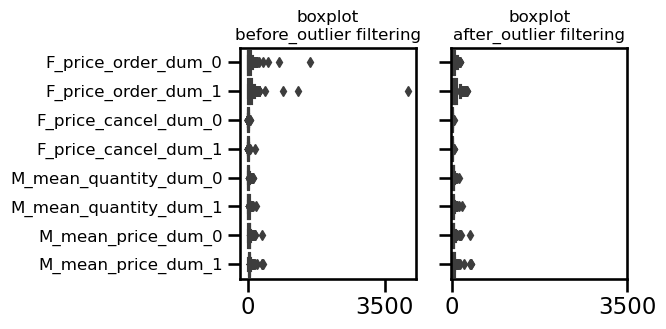

In [123]:
#이상치 제거
df = df[df.UnitPrice !=0].reset_index(drop=True)
df['totalPrice'] = df['Quantity'] *df['UnitPrice']

#날짜 변환
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
display(df.InvoiceDate.astype('str').str.split(' ').str[0].str[:-3].value_counts().sort_index().to_frame().T)

#6,7개월로 기간 분리
date_map = {
    '2010-12':0,
    '2011-01':0,
    '2011-02':0,
    '2011-03':0,
    '2011-04':0,
    '2011-05':0,
    '2011-06':1,
    '2011-07':1,
    '2011-08':1,
    '2011-09':1,
    '2011-10':1,
    '2011-11':1,
    '2011-12':1,
}

df['month_dum'] = df.InvoiceDate.astype('str').str.split(' ').str[0].str[:-3].map(date_map)


# 취소여부 
notcancel = df[df.InvoiceNo.str[0] != 'C'] .reset_index(drop=True)
cancel =df[df.InvoiceNo.str[0] == 'C'].reset_index(drop=True)


f = pd.DataFrame()
m = pd.DataFrame()

# 기간에 따른 구매 내역
f_price = notcancel.groupby(['CustomerID','month_dum'])['UnitPrice'].size().unstack()
f_price.columns = ['F_price_order_dum_' +str(i) for i in range(2)]

cancel_price = cancel.groupby(['CustomerID','month_dum'])['UnitPrice'].size().unstack().fillna(0)
cancel_price.columns = ['F_price_cancel_dum_' +str(i) for i in range(2)]

m_mean_quentity = notcancel.groupby(['CustomerID','month_dum'])['Quantity'].mean().unstack().fillna(0)
m_mean_quentity.columns = ['M_mean_quantity_dum_' +str(i) for i in range(2)]

m_mean_price = notcancel.groupby(['CustomerID','month_dum'])['totalPrice'].mean().unstack().fillna(0)
m_mean_price.columns = ['M_mean_price_dum_' +str(i) for i in range(2)]


t = pd.concat([f_price,cancel_price,m_mean_quentity,m_mean_price],axis=1).fillna(0)

print('''
UnitPrice값이 0인 경우가 존재한다. 제품금액이 0 원인 경우는 이상치로 보고 제거한다.
데이터의 경우 2010년 12월 부터 2011년 12월까지 13개월동안의 데이터이다. 전체기간을 2구간으로 나누어 각각에 대해 고객별 F와 M관련 변수들을 추출한다.
F의 경우 두 구간의 기간별 총 구매 빈도와 총 취소빈도를 만든다. 
M의 경우 두 구간의 기간별 평균 구매량과 평균 구매금액에 대한 데이터를 구한다.
최종적인 데이터는 아래와 같다.
''')

display(t.head())


t_filter = t[(t.F_price_order_dum_0 <= t.F_price_order_dum_0.quantile(0.95))]

fig,ax = plt.subplots(1,2,figsize=(5,3), sharey=True)
sns.boxplot(t, orient='h',ax=ax[0])
sns.boxplot(t_filter, orient='h',ax=ax[1])
ax[0].tick_params(axis='y', labelsize=12) 
ax[0].set_title('boxplot\nbefore_outlier filtering',fontsize=12)
ax[1].set_title('boxplot\nafter_outlier filtering',fontsize=12)
ax[1].set_xticks([0,3500],[0,3500])
ax[0].set_xticks([0,3500],[0,3500])

print('''
생성된 피쳐 데이터의 boxplot을 찍어보면 첫번째와 두번째 컬럼에서 이상치들이 보인다. 95% 백분위이상인 데이터를 걸러낸다. 
''')

## F, M feature 기반으로 군집분석 실시

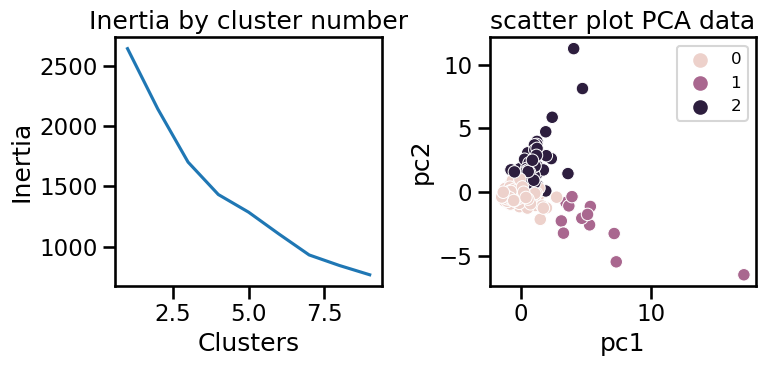

데이터 정규화를 한 후 클러스터 갯수에 따른 inertia를 추출하고 엘보우 기법을 통해 최적의 클러스터를 3개로 결정한다.
두번째 그래프는 정규화한 데이터를 pca를 통해 2개 주성분으로 차원축소한 후 클러스터링 레이블링을 시각화한 모습이다.


In [124]:
sns.set_context('talk')
ss = StandardScaler()
scaled_df = ss.fit_transform(t_filter)

km = KMeans(random_state =1)
km.fit(scaled_df)
km_pred = km.fit_predict(scaled_df)


fig,ax = plt.subplots(1,2,figsize=(8,4))

lst = []
for k in range(1, 10): 
    kmeans = KMeans(n_clusters=k,random_state=1)
    kmeans.fit(scaled_df)
    lst.append(kmeans.inertia_) 

ax[0].plot(range(1, 10), lst)
ax[0].set_xlabel('Clusters')
ax[0].set_ylabel('Inertia')
ax[0].set_title('Inertia by cluster number')



n_cluter =3
km = KMeans(n_clusters=n_cluter,random_state=1)
km_pred = km.fit_predict(scaled_df)


pca = PCA(n_components=2)
pca_df = pd.DataFrame(pca.fit_transform(scaled_df),columns =['pc1','pc2'])
pca_df['cluster_label'] = km_pred
sns.scatterplot(data =pca_df,x = 'pc1',y= 'pc2',hue='cluster_label',ax=ax[1])

fig.tight_layout()
ax[1].set_title('scatter plot PCA data')
ax[1].legend(fontsize=12)
plt.show()

print('데이터 정규화를 한 후 클러스터 갯수에 따른 inertia를 추출하고 엘보우 기법을 통해 최적의 클러스터를 3개로 결정한다.')
print('두번째 그래프는 정규화한 데이터를 pca를 통해 2개 주성분으로 차원축소한 후 클러스터링 레이블링을 시각화한 모습이다.')


## 군집 결과의 적합성을 군집 내 응집도, 군집 간 분리도의 개념을 사용해서 서술

In [125]:
inertia = km.inertia_
d = pairwise_distances_argmin_min(km.cluster_centers_, scaled_df)[1]
sep = sum(d) / len(d)

print(f'군집결과의 응집도는 {round(inertia,3)},분리도는 {round(sep,3)}값을 가진다. ')

군집결과의 응집도는 1701.515,분리도는 1.238값을 가진다. 


## 적합된 군집 별 특성에 대한 의견과 비즈니스적 판단 제시

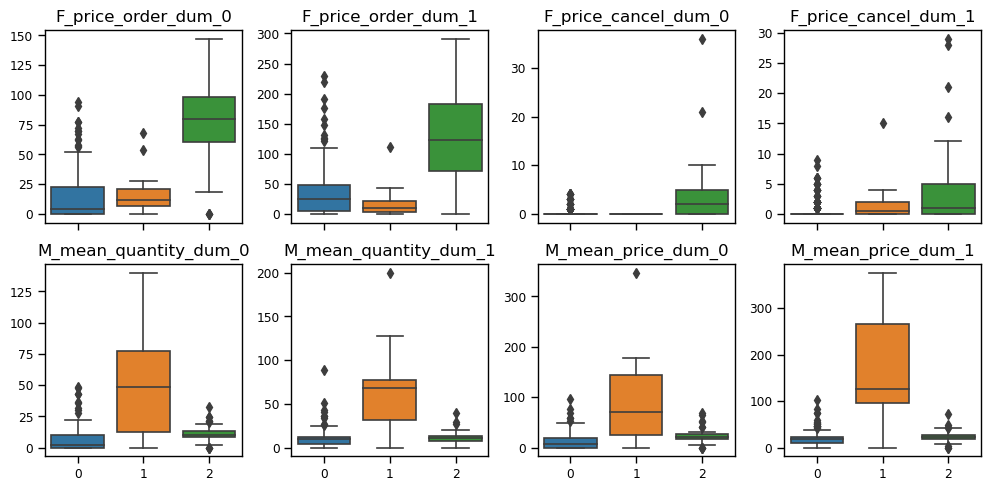

3개 군집의 데이터 분포를 나타낸 것이다. 2번 군집의 경우 F관련 변수들이 다른 두 군집에 비해 상대적으로 높게 나타남을 알 수 있다.
1번군집의 경우 M관련 변수들이 다른 두 굽지에 비행 상대적으로 높으며 2번군집의 경우 그 중간의 경향을 보인다.
이러한 특성을 확인하여 비지니스 전략을 세울수 있다. 예를들어 2번군집의 경우 구매가 다른 구집에 비해 잦은 구매를 하므로
포장 관련 할인 혜택등을 통해 고객 만족을 증가시키는 등의 전략을 세울수 있다.


In [126]:
t_filter['label'] = km_pred
sns.set_context('paper')
fig,axes = plt.subplots(2,4,figsize=(10,5),sharex=True)
for i,ax in enumerate(axes.flat):
    
    target_column =t_filter.columns[i]
    target_df = t_filter[[target_column,'label']]
    
    sns.boxplot(data =target_df , x = 'label',y = target_column,ax = ax)
    
    ax.set_ylabel('')
    ax.set_title(target_column,fontsize=12)
    ax.set_xlabel('')
    
fig.tight_layout()
plt.show()

print('3개 군집의 데이터 분포를 나타낸 것이다. 2번 군집의 경우 F관련 변수들이 다른 두 군집에 비해 상대적으로 높게 나타남을 알 수 있다.')
print('1번군집의 경우 M관련 변수들이 다른 두 굽지에 비행 상대적으로 높으며 2번군집의 경우 그 중간의 경향을 보인다.')
print('이러한 특성을 확인하여 비지니스 전략을 세울수 있다. 예를들어 2번군집의 경우 구매가 다른 구집에 비해 잦은 구매를 하므로')
print('포장 관련 할인 혜택등을 통해 고객 만족을 증가시키는 등의 전략을 세울수 있다.')

# ADP 24회 실기 문제

In [156]:
from IPython.display import display,HTML
display(HTML("<style>.container {width:95% !important;}</style>"))
import pandas as pd
pd.set_option('display.max_columns',200)

import matplotlib.pyplot as plt
import seaborn as sns


from scipy import stats


#modeling

from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score

import statsmodels.api as sm


#
import warnings 
warnings.filterwarnings('ignore')

```{admonition} 1번
**데이터 확인 및 전처리**     
- 데이터 설명
    - 성별(sex) 바이너리 : 'F' - 여성 또는 'M' - 남성     
    - 나이(age) 숫자: 15 - 22     
    - 부모님동거여부 (Pstatus) 바이너리: T: 동거 또는 'A': 별거       
    - 엄마학력(Medu) 숫자 : 0 : 없음, 1 : 초등 교육, 2 : 5-9학년, 3 - 중등 교육 또는 4 - 고등 교육    
    - 아빠학력(Fedu) 숫자 : 0 : 없음, 1 : 초등 교육, 2 : 5-9학년, 3 - 중등 교육 또는 4 - 고등 교육   
    - 주보호자(guardian) 명목형 : '어머니', '아버지' 또는 '기타'     
    - 등하교시간(traveltime) 숫자 : 1 : 15분이하, 2 : 15 ~ 30분, 3 : 30분 ~ 1시간, 4 : 1시간 이상       
    - 학습시간(studytime) 숫자 : 1 : 2시간이하, 2 : 2~5시간, 3 : 5~10시간, 4 : 10시간이상    
    - 학고횟수(failures)  숫자 : 1, 2, 3 else 4     
    - 자유시간(freetime) 숫자 : 1(매우 낮음), 2, 3, 4, 5(매우 높음)   
    - 가족관계(famrel) 숫자 : 1(매우 나쁨), 2, 3, 4, 5(우수)    
```

## 1.1 데이터 EDA 및 시각화 

In [157]:
import pandas as pd

df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/24/problem1.csv')
df.head()

,sex,age,Pstatus,Fedu,Medu,guardian,studytime,traveltime,failures,famrel,freetime,absences
0,F,18.0,A,4,4,mother,2,2.0,0,4,3.0,6
1,F,17.0,T,1,1,father,2,1.0,0,5,3.0,4
2,F,15.0,T,1,1,mother,2,1.0,3,4,3.0,10
3,F,15.0,T,2,4,mother,3,1.0,0,3,2.0,2
4,F,NaN,T,3,3,father,2,1.0,0,4,3.0,4


,sex,age,Pstatus,Fedu,Medu,guardian,studytime,traveltime,failures,famrel,freetime,absences
결측치숫자,0,3,0,0,0,0,0,3,0,0,5,0
유니크 값 숫자,2,8,2,5,5,3,4,4,4,5,5,34
types,object,float64,object,int64,int64,object,int64,float64,int64,int64,float64,int64
unique sample 3,"['F', 'M']","[18.0, 17.0, 15.0]","['A', 'T']","[4, 1, 2]","[4, 1, 3]","['mother', 'father', 'other']","[2, 3, 1]","[2.0, 1.0, 3.0]","[0, 3, 2]","[4, 5, 3]","[3.0, 2.0, 4.0]","[6, 4, 10]"


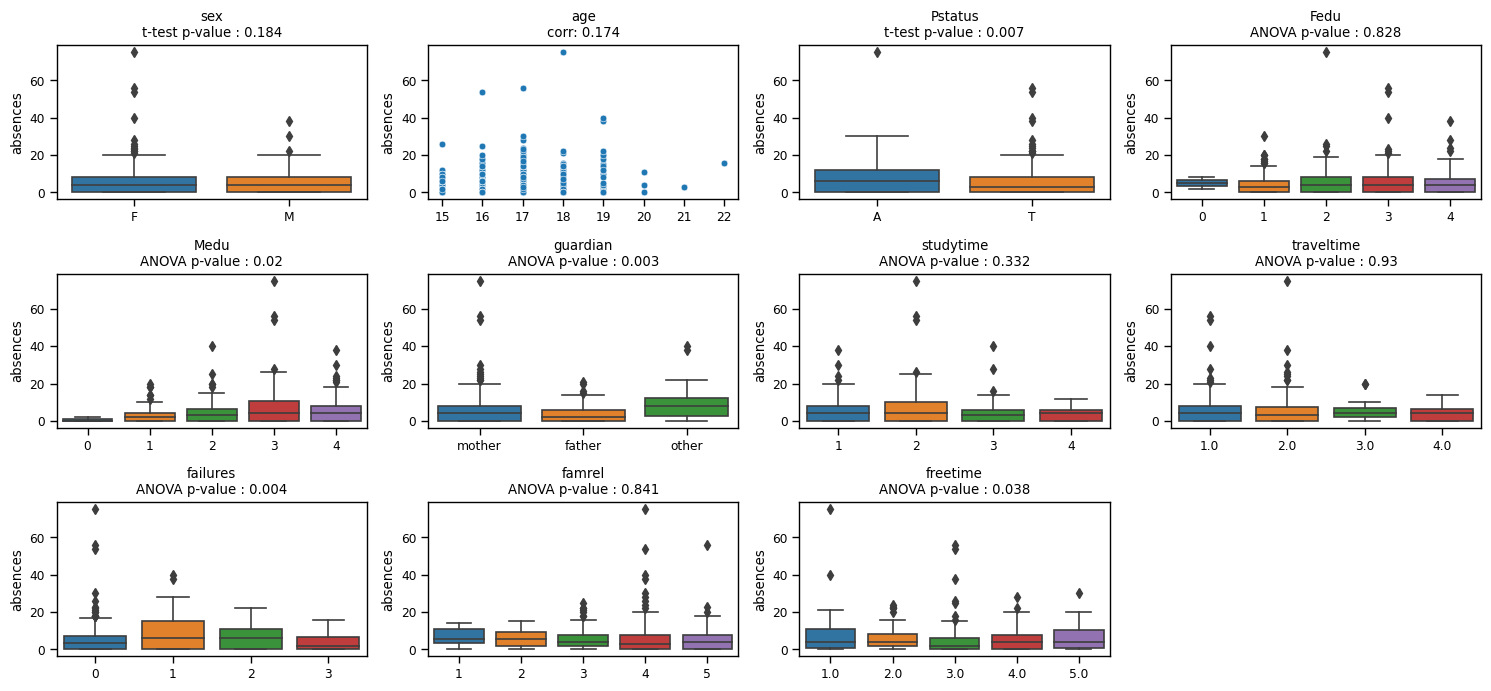

답안
age를 제외한 컬럼들은 모두 범주형 변수이다. sex화 Pstatus의 경우 uniuqe값이 2개이고 그외 범주형 변수들은 그 이상이다.
연속형 변수인 age와 absences간의 상관계수는 0.174로 낮은 상관성을 보인다.
sex와 Pstatus는 독립표본 t검정을 시행했을때 sex는 p-value가 0.184로 유의수준 0.05하에서 남녀 차이가 없으며
Pstatus의 경우 p-value는 0.007로 귀무가설을 기각한다. 즉 A,T사이에 유의한 차이가 존재한다.
두개 컬럼을 제외한 범주형 변수는 일원분산분석으로 차이가 존재하는 그룹이 있는지만 확인 한다. p-value가 0.05이하인 컬럼은
Medu,guardian,faiures,freetime이다. 그외 범주형 변수는 범주간 차이가 없다고 볼 수 있다.
결측치는 age와 traveltime,freetime 3개컬럼에서 존재한다.


In [158]:
nulls = df.isnull().sum().to_frame().T
nulls.index = ['결측치숫자']
uniques = df.nunique().to_frame().T
uniques.index = ['유니크 값 숫자']
types = df.dtypes.to_frame().rename(columns ={0:'types'}).T
un = pd.DataFrame([str(list(df[x].unique()[:3])) for x in df.columns],index=df.columns,columns =['unique sample 3']).T

t = pd.concat([nulls,uniques,types,un])
display(t)


fig,axes = plt.subplots(3,4 , figsize=(15,7))
for i,ax in enumerate(axes.flat[:-1]): # absences 제거한 11개 plot
    
    n_col_name = df.columns[i]
    target = df[[n_col_name, 'absences']]
    
    if n_col_name =='age': # numeric columns to scatter
        sns.scatterplot(data=target,x = n_col_name, y ='absences',ax=ax)
        corr = round(target.corr().iloc[0,1],3)
        
        ax.set_title(n_col_name+ f'\ncorr: {corr}')
    else:
        sns.boxplot(data=target,x = n_col_name, y ='absences',ax=ax)
        n_unique = target[n_col_name].nunique()

        if n_unique ==2: 
            # t-test
            t_statistic, p_value = stats.ttest_ind(target.query(\
                            f"{n_col_name} =='{target[n_col_name].unique()[0]}'")['absences'], \
                        target.query(\
                            f"{n_col_name} =='{target[n_col_name].unique()[1]}'")['absences'])           


            round_p =round(p_value,3)
            ax.set_title(n_col_name + f"\nt-test p-value : {round_p}")

        else:
            # anova                               
            
            f_statistic, p_value = stats.f_oneway(*[list(x)[0] for x in target.groupby([n_col_name]).agg(list).values])
            round_p =round(p_value,3)
            ax.set_title(n_col_name + f"\nANOVA p-value : {round_p}")
            
            
    ax.set_xlabel('')
    
    
axes.flat[-1].remove()
fig.tight_layout()
plt.show()
print('답안\nage를 제외한 컬럼들은 모두 범주형 변수이다. sex화 Pstatus의 경우 uniuqe값이 2개이고 그외 범주형 변수들은 그 이상이다.')
print('연속형 변수인 age와 absences간의 상관계수는 0.174로 낮은 상관성을 보인다.')
print('sex와 Pstatus는 독립표본 t검정을 시행했을때 sex는 p-value가 0.184로 유의수준 0.05하에서 남녀 차이가 없으며')
print('Pstatus의 경우 p-value는 0.007로 귀무가설을 기각한다. 즉 A,T사이에 유의한 차이가 존재한다.')
print('두개 컬럼을 제외한 범주형 변수는 일원분산분석으로 차이가 존재하는 그룹이 있는지만 확인 한다. p-value가 0.05이하인 컬럼은')
print('Medu,guardian,faiures,freetime이다. 그외 범주형 변수는 범주간 차이가 없다고 볼 수 있다.')
print('결측치는 age와 traveltime,freetime 3개컬럼에서 존재한다.')

## 1.2 결측치 처리 및 변화 시각화, 추가 전처리가 필요하다면 이유와 기대효과를 설명하라

In [159]:
df['age'].fillna(df['age'].mean(),inplace=True)
df['traveltime'].fillna(df['traveltime'].mode()[0],inplace=True)
df['freetime'].fillna(df['freetime'].mode()[0],inplace=True)

after_nulls = df.isnull().sum().to_frame().T
after_nulls.index = ['결측치 제거 후 결측치 숫자']

t = pd.concat([nulls,after_nulls])

print('답안\n결측치는 연속형 변수의 경우 평균, 범주형 변수의 경우 최빈값으로 대치한다.')
print('숫자형이지 않은 범주형 변수(sex,Pstatus)의 경우 원핫인코딩을 진행한다. 모델학습에 적합한 형태로 전처리한다')

display(t)
df_dummies = pd.get_dummies(df)
display(df_dummies.head())

답안
결측치는 연속형 변수의 경우 평균, 범주형 변수의 경우 최빈값으로 대치한다.
숫자형이지 않은 범주형 변수(sex,Pstatus)의 경우 원핫인코딩을 진행한다. 모델학습에 적합한 형태로 전처리한다


,sex,age,Pstatus,Fedu,Medu,guardian,studytime,traveltime,failures,famrel,freetime,absences
결측치숫자,0,3,0,0,0,0,0,3,0,0,5,0
결측치 제거 후 결측치 숫자,0,0,0,0,0,0,0,0,0,0,0,0


,age,Fedu,Medu,studytime,traveltime,failures,famrel,freetime,absences,sex_F,sex_M,Pstatus_A,Pstatus_T,guardian_father,guardian_mother,guardian_other
0,18.00000,4,4,2,2.0,0,4,3.0,6,1,0,1,0,0,1,0
1,17.00000,1,1,2,1.0,0,5,3.0,4,1,0,0,1,1,0,0
2,15.00000,1,1,2,1.0,3,4,3.0,10,1,0,0,1,0,1,0
3,15.00000,2,4,3,1.0,0,3,2.0,2,1,0,0,1,0,1,0
4,16.69898,3,3,2,1.0,0,4,3.0,4,1,0,0,1,1,0,0


## 1.3 결석일수 예측모델을 2개 제시하고 선택한 근거 설명

In [160]:
print(
'''결석 일수의 경우 회귀 모델을 선택해야한다. 두가지 모델은 랜덤포레스트와 선형 회귀 모델을 선택한다. 
선형회귀모델의 경우 회귀모델의 가장 기본적인 모델이기 때문에 선택했고' 
랜덤 포레스트 모델의 경우 스케일링이나 범주형 변수 인코딩 유무에 상관없이 강건한 성격을 보이기에 선택했다.''')

결석 일수의 경우 회귀 모델을 선택해야한다. 두가지 모델은 랜덤포레스트와 선형 회귀 모델을 선택한다. 
선형회귀모델의 경우 회귀모델의 가장 기본적인 모델이기 때문에 선택했고' 
랜덤 포레스트 모델의 경우 스케일링이나 범주형 변수 인코딩 유무에 상관없이 강건한 성격을 보이기에 선택했다.


## 1.4 선정한 모델 2가지 생성 및 모델의 평가 기준을 선정하고 선정 이유 설명

In [168]:
x = df_dummies.drop(columns =['absences'])
y = df_dummies['absences']


x_train,x_test,y_train,y_test = train_test_split(x,y,random_state =1,test_size=0.3)


rf = RandomForestRegressor(random_state=2)
lr = LinearRegression()

rf.fit(x_train,y_train)
lr.fit(x_train,y_train)

pred_rf = rf.predict(x_test)
pred_lr = lr.predict(x_test)

mse_rf = mean_squared_error(y_test,pred_rf)
mse_lr = mean_squared_error(y_test,pred_lr)


result =pd.DataFrame([mse_rf,mse_lr],columns =['r2_score'])
result.index = ['랜덤포레스트 mse','선형회귀 mse']

print('답안\ntrain,test분리를 7:3으로 하고 평균제곱오차(mse)값을 기준으로 모델을 평가한다.')
print('해당 지표를 선정한 이유는 예측 오차의 제곱으로 계산하기에 오차에 민감하다는 장점이 있다')
print('모델의 결과는 아래와 같다. mse값은 그 값이 작을 수록 좋은 모델이다.')
print('선형회귀 모델이 랜덤포레스트 모델보다 좋은 결과를 보였다.')
display(result)

답안
train,test분리를 7:3으로 하고 평균제곱오차(mse)값을 기준으로 모델을 평가한다.
해당 지표를 선정한 이유는 예측 오차의 제곱으로 계산하기에 오차에 민감하다는 장점이 있다
모델의 결과는 아래와 같다. mse값은 그 값이 작을 수록 좋은 모델이다.
선형회귀 모델이 랜덤포레스트 모델보다 좋은 결과를 보였다.


,r2_score
랜덤포레스트 mse,75.732523
선형회귀 mse,36.725670


## 1.5 모델이 다양한 일상 상황에서도 잘 동작한다는 것을 설명하고 시각화 하라

In [169]:
print('답안\n스터디원 예시1')
print('현재 모델성능 좋지 않음 -> 차원 축소 -> 결석일수가 random으로 퍼져있음 확인 -> 다른 독립변수 찾아서 개선시키겠다')
print('\n스터디원 예시2')
print('교차 검증을 통해 일반화 능력을 평가하고 과적합 방지 / 다양한 상황에서 잘 동작하는것 확인')
print('\n스터디원 예시3')
print('잔차가 rnadom하게 흩어져 있는것을 확인 -> 최적의 모델이 아님 -> 잘 동작 하게 하기 위한 방안 제안')
print('\n스터디원 예시4')
print('다른 추가 트리계열 모델로 학습 -> 모델 성능이 좋지 않음을 확인 -> 일상 상황 잘 동작하지 않는다 결론')

답안
스터디원 예시1
현재 모델성능 좋지 않음 -> 차원 축소 -> 결석일수가 random으로 퍼져있음 확인 -> 다른 독립변수 찾아서 개선시키겠다

스터디원 예시2
교차 검증을 통해 일반화 능력을 평가하고 과적합 방지 / 다양한 상황에서 잘 동작하는것 확인

스터디원 예시3
잔차가 rnadom하게 흩어져 있는것을 확인 -> 최적의 모델이 아님 -> 잘 동작 하게 하기 위한 방안 제안

스터디원 예시4
다른 추가 트리계열 모델로 학습 -> 모델 성능이 좋지 않음을 확인 -> 일상 상황 잘 동작하지 않는다 결론
